In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Reshape, Dropout, Activation
from keras.layers import Input, BatchNormalization, GlobalAveragePooling2D
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import plot_model, multi_gpu_model

from utils import LossHistory, plotHistory, visualization_train, visualization_data, rotation_accuracy
from keras_capsnet.layer.capsnet import PrimaryCaps, Caps, ClassesCaps, Mask, CapsCNN
from keras_capsnet.losses import margin
from keras_capsnet.activations import squash
from datasets.cifar import dataGenerator
from keras_lropt.callbacks import LRFinderAuto as LRFinder

Using TensorFlow backend.


In [2]:
# Plotting for dark theme
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# Parameters

In [3]:
num_class = 10
input_shape = (32, 32, 3)
m_train = 50000
m_test = 10000

batch_size = 16

data_augmentation = {
    'width_shift_range': 2,
    'height_shift_range': 2
}

# Dataset

In [4]:
trainGenerator = dataGenerator('train', batch_size=batch_size, reshape=False, **data_augmentation)
testGenerator = dataGenerator('test', batch_size=batch_size, reshape=False)

# Model

In [5]:
model = Sequential([    
    Convolution2D(filters=128, kernel_size=(9, 9), padding='valid', activation='relu', input_shape=input_shape),
    Convolution2D(filters=128, kernel_size=(9, 9), strides=2, padding='valid', activation='relu'),
    
    CapsCNN(64, kernel_size=(5, 5), routings=3, activation_caps=squash),

    GlobalAveragePooling2D(),
    Dense(10, name='capsule')
])

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 128)       31232     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         1327232   
_________________________________________________________________
caps_cnn_1 (CapsCNN)         (None, 4, 4, 64)          204800    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
capsule (Dense)              (None, 10)                650       
Total params: 1,563,914
Trainable params: 1,563,914
Non-trainable params: 0
_________________________________________________________________


# Training

In [7]:
model.compile(optimizer=Adam(lr=3e-4),
              loss=margin(),
              metrics={'capsule': 'categorical_accuracy'})

In [8]:
hist = model.fit_generator(trainGenerator,
                           steps_per_epoch=trainGenerator.n // trainGenerator.batch_size,
                           epochs=10,
                           validation_data=testGenerator,
                           validation_steps=testGenerator.n // testGenerator.batch_size,
                           workers=4,
                           verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
3125/3125 [==============================] - 85s 27ms/step - loss: 0.4229 - categorical_accuracy: 0.3465 - val_loss: 0.3860 - val_categorical_accuracy: 0.4218
Epoch 2/10
3125/3125 [==============================] - 82s 26ms/step - loss: 0.3672 - categorical_accuracy: 0.4463 - val_loss: 0.3489 - val_categorical_accuracy: 0.4754
Epoch 3/10
3125/3125 [==============================] - 81s 26ms/step - loss: 0.3414 - categorical_accuracy: 0.4930 - val_loss: 0.3387 - val_categorical_accuracy: 0.5002
Epoch 4/10
3125/3125 [==============================] - 82s 26ms/step - loss: 0.3235 - categorical_accuracy: 0.5242 - val_loss: 0.3210 - val_categorical_accuracy: 0.5286
Epoch 5/10
3125/3125 [==============================] - 82s 26ms/step - loss: 0.3100 - categorical_accuracy: 0.5497 - val_loss: 0.3063 - val_categorical_accuracy: 0.5549
Epoch 6/10
3125/3125 [==============================] - 80s 26ms/step - loss: 0.3001 - categorical_acc

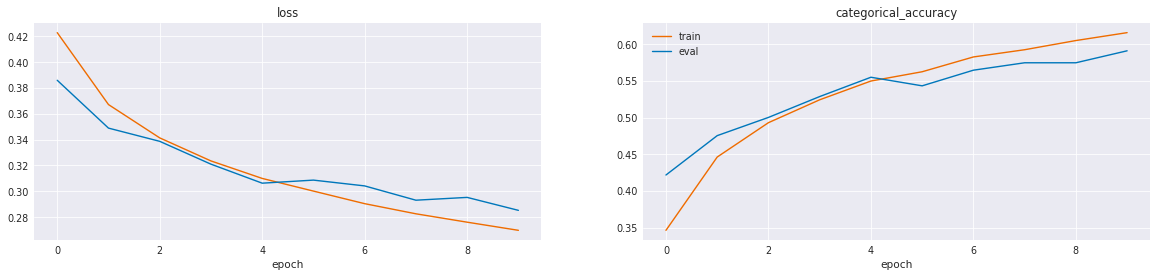

In [9]:
plotHistory(hist.history)
plt.savefig('cifar_history.png')